# 공정 4개 전처리

In [153]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [154]:
# csv 불러오기
train_data = pd.read_csv('trim_train_data.csv')
test_data = pd.read_csv('trim_test_data.csv')

### 1. 기본 전처리

In [155]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

In [156]:
# Wip Line 열 제거
wip_line_columns = train_data.filter(like='Wip Line').columns

train_data.drop(columns=wip_line_columns, inplace=True)
test_data.drop(columns=wip_line_columns, inplace=True)

In [157]:
# Process Desc 열 제거
Process_Desc_col = train_data.filter(like='Process Desc').columns

train_data.drop(columns=Process_Desc_col, inplace=True)
test_data.drop(columns=Process_Desc_col, inplace=True)

In [158]:
# Insp. Seq No 열 제거
Insp_Seq_No_col = train_data.filter(like='Insp. Seq No').columns

train_data.drop(columns=Insp_Seq_No_col, inplace=True)
test_data.drop(columns=Insp_Seq_No_col, inplace=True)

In [159]:
# Insp Judge Code 열 제거
Insp_Judge_Code_col = train_data.filter(like='Insp Judge Code').columns

train_data.drop(columns=Insp_Judge_Code_col, inplace=True)
test_data.drop(columns=Insp_Judge_Code_col, inplace=True)

### 2. 제품 구분

- receip no, workorder, model.suffix

In [160]:
### Receip_No
# 파생변수 생성: Receip_No 3개의 컬럼 값이 모두 동일하면 해당 값을 저장, 아니면 diff
train_data['Receip_No'] = train_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)
test_data['Receip_No'] = test_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)

# 필요없는 변수 삭제
train_data = train_data.drop(columns=['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])
test_data = test_data.drop(columns=['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])

In [161]:
### model_receip
# 파생변수 생성: Receip No와 Model.Suffix의 조합
train_data['model_receip'] = train_data['Model.Suffix_Dam'] + '_' + train_data['Receip_No'].astype(str)
test_data['model_receip'] = test_data['Model.Suffix_Dam'] + '_' + test_data['Receip_No'].astype(str)

# 필요없는 변수 삭제
train_data = train_data.drop(columns=['Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_data = test_data.drop(columns=['Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [162]:
### workorder_receip

# Workorder -뒤의 번호 구분을 제거
train_data['cleaned_workorder'] = train_data['Workorder_Dam'].str.split('-').str[0]
test_data['cleaned_workorder'] = test_data['Workorder_Dam'].str.split('-').str[0]

# Workorder 앞 5자리
#train_data['cleaned_workorder'] = train_data['Workorder_Dam'].str[:5]
#test_data['cleaned_workorder'] = test_data['Workorder_Dam'].str[:5]

# 파생변수 생성: Receip No와 workorder의 조합
train_data['workorder_receip'] = train_data['cleaned_workorder'] + '_' + train_data['Receip_No'].astype(str)
test_data['workorder_receip'] = test_data['cleaned_workorder'] + '_' + test_data['Receip_No'].astype(str)

# 필요없는 변수 삭제
train_data = train_data.drop(columns=['Receip_No', 'cleaned_workorder', 'Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_data = test_data.drop(columns=['Receip_No', 'cleaned_workorder', 'Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

### 3. 공통 변수 (dam, fill1, fill2)

- workmode

In [163]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

In [164]:
# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

- equipment
<br>(dispenser1 & dispenser2 변수를 만들 경우 다른 변수들에 의해 이미 설명이 되는 변수라 상관계수가 너무 높아서 제거하게 됨. 따라서 equipment가 같은지만 판단하는 파생변수 사용)

In [165]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
Equipment_col2 = test_data.filter(like='Equipment').columns

new_train = train_data.filter(items=Equipment_col)
new_test = test_data.filter(items=Equipment_col2)

# Equipment_same_num 파생변수 생성
def determine_equipment_same_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
       (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return 1
    else:
        return 0

train_data['Equipment_same_num'] = new_train.apply(determine_equipment_same_num, axis=1)
test_data['Equipment_same_num'] = new_test.apply(determine_equipment_same_num, axis=1)

train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])

- palletID

In [166]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 diff의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['PalletID_Collect_Result'] = df.apply(
        lambda row: row['PalletID Collect Result_Dam'] 
                    if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) 
                    else 'diff', 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [167]:
# 제거할 변수 목록
columns_to_drop = [
    'PalletID Collect Result_Dam',
    'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

- production Qty

In [168]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['Production_Qty_Collect_Result'] = df.apply(
        lambda row: row['Production Qty Collect Result_Dam'] 
                    if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [169]:
# 제거할 변수 목록
columns_to_drop = [
    'Production Qty Collect Result_Dam',
    'Production Qty Collect Result_Fill1',
    'Production Qty Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 4. CURE 변수
- dam -> distance 파생변수 (standby는 단일값, start와 end는 값은 여러개지만 distance 파생변수를 만들었을 때 더 의미있었음)
- fill2 -> 변수값 범주화 (start, end, standby를 각각 범주화했을 때가 합쳐서 distance 만들었을 때보다 더 의미있었음)

In [170]:
### dam
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

In [171]:
### fill2
# UV 경화 좌표 합치기
def create_coordinate_columns(data):
    # Fill2
    # cure end
    data['cure_end_position_XZ_Fill2'] = (
        data['CURE END POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE END POSITION Z Collect Result_Fill2'].astype(str) 
    )

    # cure start
    data['cure_start_position_XZ_Fill2'] = (
        data['CURE START POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE START POSITION Z Collect Result_Fill2'].astype(str) 
    )

    # cure standby
    data['cure_standby_position_XZ_Fill2'] = (
        data['CURE STANDBY POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE STANDBY POSITION Z Collect Result_Fill2'].astype(str) 
    )

# train_data와 test_data에 대해 함수 호출
create_coordinate_columns(train_data)
create_coordinate_columns(test_data)

In [172]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Z Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',

    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 5. HEAD 변수

- dam

In [173]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [174]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['HEAD NORMAL DISTANCE_TRIANGLE_area_Dam'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Dam'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [175]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'

    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [176]:
# Dam 노즐 zero 위치 Z좌표 드롭
train_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)
test_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)

- fill1

In [177]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [178]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [179]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'

    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

- fill2

In [180]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [181]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 6. Resin 변수

- dam

In [182]:
# volume*time 파생변수 - Dam
train_data['volume_time_multip_stage1_Dam'] = train_data['Dispense Volume(Stage1) Collect Result_Dam'] * train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
train_data['volume_time_multip_stage2_Dam'] = train_data['Dispense Volume(Stage2) Collect Result_Dam'] * train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
train_data['volume_time_multip_stage3_Dam'] = train_data['Dispense Volume(Stage3) Collect Result_Dam'] * train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

train_data['volume_time_multip_avg_Dam'] = (train_data['volume_time_multip_stage1_Dam'] + 
                                            train_data['volume_time_multip_stage2_Dam'] + 
                                            train_data['volume_time_multip_stage3_Dam']) / 3

# volume*time 파생변수 - Dam
test_data['volume_time_multip_stage1_Dam'] = test_data['Dispense Volume(Stage1) Collect Result_Dam'] * test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
test_data['volume_time_multip_stage2_Dam'] = test_data['Dispense Volume(Stage2) Collect Result_Dam'] * test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
test_data['volume_time_multip_stage3_Dam'] = test_data['Dispense Volume(Stage3) Collect Result_Dam'] * test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

test_data['volume_time_multip_avg_Dam'] = (test_data['volume_time_multip_stage1_Dam'] + 
                                            test_data['volume_time_multip_stage2_Dam'] + 
                                            test_data['volume_time_multip_stage3_Dam']) / 3

In [183]:
# 삭제할 열 목록 추가
columns_to_drop = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'volume_time_multip_stage1_Dam',
    'volume_time_multip_stage2_Dam',
    'volume_time_multip_stage3_Dam'
]

train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

- fill1

In [184]:
# volume*time 파생변수 - Fill1
train_data['volume_time_multip_stage1_Fill1'] = train_data['Dispense Volume(Stage1) Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
train_data['volume_time_multip_stage2_Fill1'] = train_data['Dispense Volume(Stage2) Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
train_data['volume_time_multip_stage3_Fill1'] = train_data['Dispense Volume(Stage3) Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

train_data['volume_time_multip_avg_Fill1'] = (train_data['volume_time_multip_stage1_Fill1'] + 
                                            train_data['volume_time_multip_stage2_Fill1'] + 
                                            train_data['volume_time_multip_stage3_Fill1']) / 3

# volume*time 파생변수 - Fill1
test_data['volume_time_multip_stage1_Fill1'] = test_data['Dispense Volume(Stage1) Collect Result_Fill1'] * test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
test_data['volume_time_multip_stage2_Fill1'] = test_data['Dispense Volume(Stage2) Collect Result_Fill1'] * test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
test_data['volume_time_multip_stage3_Fill1'] = test_data['Dispense Volume(Stage3) Collect Result_Fill1'] * test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

test_data['volume_time_multip_avg_Fill1'] = (test_data['volume_time_multip_stage1_Fill1'] + 
                                            test_data['volume_time_multip_stage2_Fill1'] + 
                                            test_data['volume_time_multip_stage3_Fill1']) / 3

In [185]:
# 삭제할 열 목록 추가
columns_to_drop = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'volume_time_multip_stage1_Fill1',
    'volume_time_multip_stage2_Fill1',
    'volume_time_multip_stage3_Fill1'
]

train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

### 7. Circle, Line 변수

In [186]:
### circle
# 열 이름 변경
train_data.rename(columns={
    'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1_Circle_Distance_Speed_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2_Circle_Distance_Speed_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3_Circle_Distance_Speed_Dam'
}, inplace=True)

test_data.rename(columns={
    'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1_Circle_Distance_Speed_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2_Circle_Distance_Speed_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3_Circle_Distance_Speed_Dam'
}, inplace=True)

In [187]:
# 제거할 변수 목록
columns_to_drop = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [188]:
### line
# line1&3과 line2&4를 합친 파생변수 생성 함수
def check_distance_speed(data, stage):
    # 단계에 따라 라인 번호 정의
    line_pairs = [(1, 3), (2, 4)]
    
    # 각 라인 쌍에 대해 반복
    for line1, line2 in line_pairs:
        line1_name = f'Stage{stage} Line{line1} Distance Speed Collect Result_Dam'
        line2_name = f'Stage{stage} Line{line2} Distance Speed Collect Result_Dam'
        
        # 새로운 열 이름 설정
        new_col_name = f'stage{stage}_line{line1}{line2}_distance_speed_Dam'
        
        # 조건에 따라 값 설정
        data[new_col_name] = data.apply(
            lambda row: row[line1_name] if row[line1_name] == row[line2_name] else 'diff', axis=1
        )

# train_data와 test_data 모두에 대해 함수 호출
for stage in range(1, 4):
    check_distance_speed(train_data, stage)
    check_distance_speed(test_data, stage)

In [189]:
# train_data에서 변수들을 object 타입으로 변환
train_data['stage1_line24_distance_speed_Dam'] = train_data['stage1_line24_distance_speed_Dam'].astype(object)
train_data['stage2_line24_distance_speed_Dam'] = train_data['stage2_line24_distance_speed_Dam'].astype(object)
train_data['stage3_line24_distance_speed_Dam'] = train_data['stage3_line24_distance_speed_Dam'].astype(object)

# test_data에서 변수들을 object 타입으로 변환
test_data['stage1_line24_distance_speed_Dam'] = test_data['stage1_line24_distance_speed_Dam'].astype(object)
test_data['stage2_line24_distance_speed_Dam'] = test_data['stage2_line24_distance_speed_Dam'].astype(object)
test_data['stage3_line24_distance_speed_Dam'] = test_data['stage3_line24_distance_speed_Dam'].astype(object)

In [190]:
# 제거할 변수 목록
columns_to_drop = [
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 8. Thickness 변수

In [191]:
# 세 개 컬럼의 평균을 계산하여 새로운 컬럼 생성
train_data['average_thickness_Dam'] = train_data[['THICKNESS 1 Collect Result_Dam', 
                                                  'THICKNESS 2 Collect Result_Dam', 
                                                  'THICKNESS 3 Collect Result_Dam']].mean(axis=1)

test_data['average_thickness_Dam'] = test_data[['THICKNESS 1 Collect Result_Dam', 
                                                'THICKNESS 2 Collect Result_Dam', 
                                                'THICKNESS 3 Collect Result_Dam']].mean(axis=1)

In [192]:
# 삭제할 컬럼 리스트
columns_to_drop = [
    'THICKNESS 1 Collect Result_Dam',
    'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam'
]

# 지정한 컬럼 삭제
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 9. Autoclave 관련 변수

In [193]:
# 각 압력과 시간의 곱을 담은 새로운 컬럼 생성
train_data['1st_pressure_time_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure 1st Pressure Unit Time_AutoClave']
train_data['2nd_pressure_time_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave']
train_data['3rd_pressure_time_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave']

train_data['avg_pressure_time_AutoClave'] = (train_data['1st_pressure_time_AutoClave'] +
                                             train_data['2nd_pressure_time_AutoClave'] +
                                             train_data['3rd_pressure_time_AutoClave']) / 3

In [194]:
# 각 압력과 시간의 곱을 담은 새로운 컬럼 생성
test_data['1st_pressure_time_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure 1st Pressure Unit Time_AutoClave']
test_data['2nd_pressure_time_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave']
test_data['3rd_pressure_time_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave']

test_data['avg_pressure_time_AutoClave'] = (test_data['1st_pressure_time_AutoClave'] +
                                             test_data['2nd_pressure_time_AutoClave'] +
                                             test_data['3rd_pressure_time_AutoClave']) / 3

In [195]:
# 삭제할 컬럼 리스트
columns_to_drop = [
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
]

# 지정한 컬럼 삭제
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 10. Time 변수

In [196]:
# 총시간 대비 비율 변수
def calculate_total_time_and_ratios(data):
    data['total_time'] = (
        data['Machine Tact time Collect Result_Dam'] +
        data['Machine Tact time Collect Result_Fill1'] +
        data['Machine Tact time Collect Result_Fill2'] +
        data['Chamber Temp. Unit Time_AutoClave']
    )
    data['time_ratio_Dam'] = (data['Machine Tact time Collect Result_Dam'] / data['total_time']).round(3)
    data['time_ratio_Fill1'] = (data['Machine Tact time Collect Result_Fill1'] / data['total_time']).round(3)
    data['time_ratio_Fill2'] = (data['Machine Tact time Collect Result_Fill2'] / data['total_time']).round(3)
    data['time_ratio_AutoClave'] = (data['Chamber Temp. Unit Time_AutoClave'] / data['total_time']).round(3)
    return data

# train_data와 test_data에 함수 적용
train_data = calculate_total_time_and_ratios(train_data)
test_data = calculate_total_time_and_ratios(test_data)

In [197]:
# 변수 제거
train_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

### 11. 변수 확인

In [198]:
# 삭제할 변수 리스트
columns_to_drop = [
    'Chamber Temp. Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
]

train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [199]:
# 값의 종류가 1개이고 결측값이 없는 열을 제거하는 함수
def drop_single_value_columns(df):
    cols_to_drop = [col for col in df.columns if col != 'target' and df[col].nunique() == 1 and df[col].isnull().sum() == 0]
    df_dropped = df.drop(columns=cols_to_drop)
    return df_dropped, cols_to_drop

# train_data와 test_data에서 해당 열 제거 및 삭제된 열 이름과 개수 출력
train_data, train_cols_dropped = drop_single_value_columns(train_data)
test_data, test_cols_dropped = drop_single_value_columns(test_data)

# print("삭제된 train_data 열 이름:", train_cols_dropped)
print("삭제된 train_data 열 개수:", len(train_cols_dropped))

# print("삭제된 test_data 열 이름:", test_cols_dropped)
print("삭제된 test_data 열 개수:", len(test_cols_dropped))

삭제된 train_data 열 개수: 37
삭제된 test_data 열 개수: 37


### 12. target encoding

In [200]:
# object 타입의 변수 출력
train_object_columns = train_data.select_dtypes(include=['object']).columns
test_object_columns = test_data.select_dtypes(include=['object']).columns

print(train_object_columns, f" train_object_columns 갯수 : {len(train_object_columns)}")
print(test_object_columns, f" test_object_columns 갯수 : {len(test_object_columns)}")

# 각 object 변수의 고유 값 개수 출력
print("\nTrain Data:")
for col in train_object_columns:
    unique_count = train_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

print("\nTest Data:")
for col in test_object_columns:
    unique_count = test_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

Index(['target', 'model_receip', 'workorder_receip', 'PalletID_Collect_Result',
       'cure_end_position_XZ_Fill2', 'cure_start_position_XZ_Fill2',
       'cure_standby_position_XZ_Fill2', 'stage1_line13_distance_speed_Dam',
       'stage1_line24_distance_speed_Dam', 'stage2_line13_distance_speed_Dam',
       'stage2_line24_distance_speed_Dam', 'stage3_line13_distance_speed_Dam',
       'stage3_line24_distance_speed_Dam'],
      dtype='object')  train_object_columns 갯수 : 13
Index(['Set ID', 'model_receip', 'workorder_receip', 'PalletID_Collect_Result',
       'cure_end_position_XZ_Fill2', 'cure_start_position_XZ_Fill2',
       'cure_standby_position_XZ_Fill2', 'stage1_line13_distance_speed_Dam',
       'stage1_line24_distance_speed_Dam', 'stage2_line13_distance_speed_Dam',
       'stage2_line24_distance_speed_Dam', 'stage3_line13_distance_speed_Dam',
       'stage3_line24_distance_speed_Dam'],
      dtype='object')  test_object_columns 갯수 : 13

Train Data:
target unique 값 갯수: 2
model_

In [201]:
# 전체 평균 타겟 값 계산 (abnormal 전체 비율)
train_data['target_01'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)
global_mean = train_data['target_01'].mean()

In [202]:
# 적용할 열 리스트
columns_to_encode = [
    'model_receip',
    'workorder_receip',
    'PalletID_Collect_Result',
    'cure_end_position_XZ_Fill2',
    'cure_start_position_XZ_Fill2',
    'cure_standby_position_XZ_Fill2',
    'stage1_line13_distance_speed_Dam',
    'stage1_line24_distance_speed_Dam',
    'stage2_line13_distance_speed_Dam',
    'stage2_line24_distance_speed_Dam',
    'stage3_line13_distance_speed_Dam',
    'stage3_line24_distance_speed_Dam'
]

# 전체 데이터의 평균 타겟값
global_mean = train_data['target_01'].mean()

for column in columns_to_encode:
    # 각 column에 대한 평균 타겟값과 카운트 계산
    target_mean = train_data.groupby(column)['target_01'].mean()
    count = train_data.groupby(column)['target_01'].count()

    # 스무딩 적용
    '''
    추천 알파 값:
    0.5: 일반적으로 많이 사용되는 값으로, 기존 데이터와 전체 평균 간의 균형을 잘 맞춰줍니다.
    0.3: 데이터가 충분히 많고 각 카테고리의 타겟 값이 잘 분포되어 있을 때 사용.
    0.7: 데이터가 적거나 특정 카테고리가 상대적으로 적을 때 사용.
    '''
    alpha = 0.5
    smoothed_values = (target_mean * count + global_mean * alpha) / (count + alpha)

    # 인코딩된 값을 데이터프레임에 추가
    train_data[f'{column}_encoded'] = train_data[column].map(smoothed_values)

    # test_data에 동일한 인코딩 값을 추가
    encoding_dict = train_data.groupby(column)[f'{column}_encoded'].first().to_dict()
    test_data[f'{column}_encoded'] = test_data[column].map(encoding_dict)

In [203]:
# 삭제할 열 리스트
columns_to_drop = [
    'target_01',
    'model_receip',
    'workorder_receip',
    'PalletID_Collect_Result',
    'cure_end_position_XZ_Fill2',
    'cure_start_position_XZ_Fill2',
    'cure_standby_position_XZ_Fill2',
    'stage1_line13_distance_speed_Dam',
    'stage1_line24_distance_speed_Dam',
    'stage2_line13_distance_speed_Dam',
    'stage2_line24_distance_speed_Dam',
    'stage3_line13_distance_speed_Dam',
    'stage3_line24_distance_speed_Dam'
]

# train_data와 test_data에서 열 드랍
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

In [204]:
# info 잘리지 않게 출력
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 50 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   CURE SPEED Collect Result_Dam                   40506 non-null  int64  
 1   DISCHARGED SPEED OF RESIN Collect Result_Dam    40506 non-null  int64  
 2   Head Clean Position Z Collect Result_Dam        40506 non-null  float64
 3   Head Purge Position Z Collect Result_Dam        40506 non-null  float64
 4   Head Zero Position Y Collect Result_Dam         40506 non-null  float64
 5   Stage1_Circle_Distance_Speed_Dam                40506 non-null  float64
 6   Stage2_Circle_Distance_Speed_Dam                40506 non-null  float64
 7   Stage3_Circle_Distance_Speed_Dam                40506 non-null  float64
 8   WorkMode Collect Result                         40506 non-null  float64
 9   Chamber Temp. Collect Result_AutoClave 

In [205]:
# info 잘리지 않게 출력
test_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 51 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Set ID                                          17361 non-null  object 
 1   CURE SPEED Collect Result_Dam                   17361 non-null  int64  
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam    17361 non-null  int64  
 3   Head Clean Position Z Collect Result_Dam        17361 non-null  float64
 4   Head Purge Position Z Collect Result_Dam        17361 non-null  float64
 5   Head Zero Position Y Collect Result_Dam         17361 non-null  float64
 6   Stage1_Circle_Distance_Speed_Dam                17361 non-null  float64
 7   Stage2_Circle_Distance_Speed_Dam                17361 non-null  float64
 8   Stage3_Circle_Distance_Speed_Dam                17361 non-null  float64
 9   WorkMode Collect Result                

<br>
<br>

---

### <변수 검정>

In [206]:
from scipy import stats

# 수치형 변수
numeric_variables = [
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'Stage1_Circle_Distance_Speed_Dam',
    'Stage2_Circle_Distance_Speed_Dam',
    'Stage3_Circle_Distance_Speed_Dam',
    'Chamber Temp. Collect Result_AutoClave',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'CURE SPEED Collect Result_Fill2',
    'CURE_DISTANCE_Dam',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
    'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2',
    'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
    'volume_time_multip_avg_Dam',
    'volume_time_multip_avg_Fill1',
    'average_thickness_Dam',
    '1st_pressure_time_AutoClave',
    '2nd_pressure_time_AutoClave',
    '3rd_pressure_time_AutoClave',
    'avg_pressure_time_AutoClave',
    'time_ratio_Dam',
    'time_ratio_Fill1',
    'time_ratio_Fill2',
    'time_ratio_AutoClave',
] 

# 결과를 저장할 리스트
results = []

for numeric_variable in numeric_variables:
    # 'AbNormal'과 'Normal'로 그룹화
    group_abnormal = train_data[train_data['target'] == 'AbNormal'][numeric_variable]
    group_normal = train_data[train_data['target'] == 'Normal'][numeric_variable]

    # t-검정 수행
    t_stat, p_value = stats.ttest_ind(group_abnormal, group_normal)

    # 결과 저장
    results.append({
        'variable': numeric_variable,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 유의미하지 않은 변수만 필터링
non_significant_results = results_df[results_df['p_value'] >= 0.05]

# 결과 출력
print("통계적으로 유의미하지 않은 변수:")
print(non_significant_results)

통계적으로 유의미하지 않은 변수:
                                    variable  t_statistic   p_value  \
7            CURE SPEED Collect Result_Fill2    -0.976735  0.328706   
8                          CURE_DISTANCE_Dam     1.437254  0.150654   
12  HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1    -0.994804  0.319837   
15  HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2     1.272064  0.203358   
16  HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2     1.275423  0.202167   
17  HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2     1.273313  0.202914   
21               1st_pressure_time_AutoClave    -0.011984  0.990438   

    significant  
7         False  
8         False  
12        False  
15        False  
16        False  
17        False  
21        False  


In [207]:
from sklearn.feature_selection import chi2

# 범주형 변수
feature_columns = [
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'WorkMode Collect Result',
    'Head Purge Position Z Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill2',
    'Equipment_same_num',
    'Production_Qty_Collect_Result'
]  

# 'normal'을 0으로, 'abnormal'을 1로 매핑
train_data['target01'] = train_data['target'].map({'Normal': 0, 'AbNormal': 1})

# 독립 변수와 타깃 변수 분리
X = train_data[feature_columns]  
y = train_data['target01']

# 카이제곱 검정 수행
chi2_scores, p_values = chi2(X, y)

# 유의미하지 않은 변수 필터링 (p-value가 0.05 이상인 변수)
non_significant_features = X.columns[p_values >= 0.05]

# 결과 확인
print("통계적으로 유의미하지 않은 변수:", non_significant_features.tolist())
print("p-value 값:")
for feature, p_value in zip(X.columns, p_values):
    if p_value >= 0.05:
        print(f"{feature}: {p_value:.4f}")

통계적으로 유의미하지 않은 변수: ['Head Purge Position Z Collect Result_Dam', 'Head Zero Position Y Collect Result_Dam', 'Head Purge Position Z Collect Result_Fill2', 'Equipment_same_num']
p-value 값:
Head Purge Position Z Collect Result_Dam: 0.2451
Head Zero Position Y Collect Result_Dam: 0.3766
Head Purge Position Z Collect Result_Fill2: 0.1003
Equipment_same_num: 0.4959


In [208]:
# 삭제할 열 리스트
columns_to_drop = [
    'CURE SPEED Collect Result_Fill2',
    'CURE_DISTANCE_Dam',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2',
    'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
    'Head Purge Position Z Collect Result_Dam', 
    'Head Zero Position Y Collect Result_Dam', 
    'Head Purge Position Z Collect Result_Fill2', 
    'target01'
]

# train_data와 test_data에서 열 드랍
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

### <범주화>

In [57]:
variables = [
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'Stage1_Circle_Distance_Speed_Dam',
    'Stage2_Circle_Distance_Speed_Dam',
    'Stage3_Circle_Distance_Speed_Dam',
    'Chamber Temp. Collect Result_AutoClave',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
    'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1',
    'volume_time_multip_avg_Dam',
    'volume_time_multip_avg_Fill1',
    'average_thickness_Dam',
    '1st_pressure_time_AutoClave',
    '2nd_pressure_time_AutoClave',
    '3rd_pressure_time_AutoClave',
    'avg_pressure_time_AutoClave',
    'time_ratio_Dam',
    'time_ratio_Fill1',
    'time_ratio_Fill2',
    'time_ratio_AutoClave',
    'Head Clean Position Z Collect Result_Dam',
    'WorkMode Collect Result',
    'Head Purge Position Z Collect Result_Fill1',
    'Equipment_same_num',
    'Production_Qty_Collect_Result'
]

# 각 변수의 고유값 개수 출력
for var in variables:
    unique_count = train_data[var].nunique()  # 고윳값 개수 계산
    print(f'변수 {var}의 고유값 개수: {unique_count}')

변수 CURE SPEED Collect Result_Dam의 고유값 개수: 5
변수 DISCHARGED SPEED OF RESIN Collect Result_Dam의 고유값 개수: 3
변수 Stage1_Circle_Distance_Speed_Dam의 고유값 개수: 7
변수 Stage2_Circle_Distance_Speed_Dam의 고유값 개수: 9
변수 Stage3_Circle_Distance_Speed_Dam의 고유값 개수: 7
변수 Chamber Temp. Collect Result_AutoClave의 고유값 개수: 26
변수 DISCHARGED SPEED OF RESIN Collect Result_Fill1의 고유값 개수: 4
변수 HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam의 고유값 개수: 25
변수 HEAD NORMAL DISTANCE_TRIANGLE_area_Dam의 고유값 개수: 49
변수 HEAD NORMAL DISTANCE_TRIANGLE_height_Dam의 고유값 개수: 43
변수 HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1의 고유값 개수: 49
변수 HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1의 고유값 개수: 51
변수 volume_time_multip_avg_Dam의 고유값 개수: 180
변수 volume_time_multip_avg_Fill1의 고유값 개수: 161
변수 average_thickness_Dam의 고유값 개수: 8
변수 1st_pressure_time_AutoClave의 고유값 개수: 112
변수 2nd_pressure_time_AutoClave의 고유값 개수: 193
변수 3rd_pressure_time_AutoClave의 고유값 개수: 115
변수 avg_pressure_time_AutoClave의 고유값 개수: 1959
변수 time_ratio_Dam의 고유값 개수: 154
변수 time_ratio_Fill1의 고유값 개수: 11

In [58]:
# 범주화 해줄 변수
'Chamber Temp. Collect Result_AutoClave'
'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'
'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam'
'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam'
'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1'
'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1'
'volume_time_multip_avg_Dam'
'volume_time_multip_avg_Fill1'
'1st_pressure_time_AutoClave'
'2nd_pressure_time_AutoClave'
'3rd_pressure_time_AutoClave'
'avg_pressure_time_AutoClave'
'time_ratio_Dam'
'time_ratio_Fill1'
'time_ratio_Fill2'
'time_ratio_AutoClave'
'Production_Qty_Collect_Result'

'Production_Qty_Collect_Result'

In [59]:
### 한글 및 부호 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic' #한글
mpl.rcParams['axes.unicode_minus'] = False #마이너스 부호

In [60]:
def plot_with_counts(category_column, target_column='target', data=train_data):
    # 비율 계산
    count_df = data.groupby([category_column, target_column]).size().unstack(fill_value=0)
    count_df = count_df.div(count_df.sum(axis=1), axis=0)

    # 개수 계산
    count_values = data.groupby([category_column, target_column]).size().unstack(fill_value=0)

    # 비율 시각화
    count_df.plot(kind='bar', stacked=True, color=['salmon', 'lightgrey'], figsize=(8, 4))

    plt.legend(title='Target', loc='upper right')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 그래프 위에 비율 및 개수 표시
    for i in range(count_df.shape[0]):
        for j in range(count_df.shape[1]):
            # 비율 표시
            plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')
            # 개수 표시
            plt.text(i, count_df.iloc[i, :j].sum() + count_df.iloc[i, j] / 2 + 0.05, f"{count_values.iloc[i, j]}", ha='center', color='black')

    plt.xlabel(category_column)
    plt.ylabel('Proportion')
    plt.show()

In [61]:
# IQR 기준으로 범주화하는 함수
def categorize_by_iqr(df, column):
    # IQR 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 범주화 함수
    def categorize(value):
        if value < lower_bound:
            return '아주 낮음'
        elif lower_bound <= value < Q1:
            return '낮음'
        elif Q1 <= value <= Q3:
            return '정상'
        elif Q3 < value <= upper_bound:
            return '높음'
        else:
            return '아주 높음'

    # 범주화 적용
    df[column] = df[column].apply(categorize)

In [62]:
# 원하는 범주 개수로 범주화하는 함수
def categorize_column(data, column_name, num_categories):
    """
    주어진 데이터프레임의 특정 열을 범주화하는 함수.
    
    :param data: DataFrame, 범주화할 데이터프레임
    :param column_name: str, 범주화할 열의 이름
    :param num_categories: int, 생성할 범주 수
    """
    # 최소값과 최대값 계산
    column_min = data[column_name].min()
    column_max = data[column_name].max()

    # 구간 계산
    bins = np.linspace(column_min, column_max, num_categories + 1)

    # 범주화
    category_labels = [f'Category {i+1}' for i in range(num_categories)]
    categorized_data = pd.cut(data[column_name], bins=bins, labels=category_labels, include_lowest=True, right=False)

    # 외부 값에 대한 범주 추가
    categorized_data = categorized_data.cat.add_categories(['Below Min', 'Above Max'])
    categorized_data[data[column_name] < column_min] = 'Below Min'
    categorized_data[data[column_name] > column_max] = 'Above Max'

    # 새로운 열 이름 생성
    new_column_name = f"{column_name}_category"
    data[new_column_name] = categorized_data

- Chamber Temp

In [63]:
'''
변수 Chamber Temp. Collect Result_AutoClave의 고유값 개수: 26
'''

'\n변수 Chamber Temp. Collect Result_AutoClave의 고유값 개수: 26\n'

In [64]:
train_data['Chamber Temp. Collect Result_AutoClave'].describe()

count    40506.000000
mean        51.691725
std          2.878083
min         32.000000
25%         49.000000
50%         52.000000
75%         54.000000
max         59.000000
Name: Chamber Temp. Collect Result_AutoClave, dtype: float64

In [65]:
# IQR 범주화
categorize_by_iqr(train_data, 'Chamber Temp. Collect Result_AutoClave')
categorize_by_iqr(test_data, 'Chamber Temp. Collect Result_AutoClave')

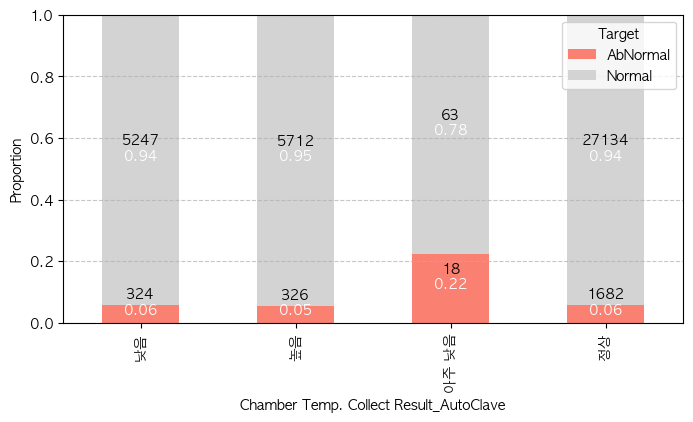

In [66]:
plot_with_counts('Chamber Temp. Collect Result_AutoClave')

- HEAD NORMAL DISTANCE

In [67]:
'''
변수 HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam의 고유값 개수: 25
변수 HEAD NORMAL DISTANCE_TRIANGLE_area_Dam의 고유값 개수: 49
변수 HEAD NORMAL DISTANCE_TRIANGLE_height_Dam의 고유값 개수: 43
변수 HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1의 고유값 개수: 49
변수 HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1의 고유값 개수: 51
'''

'\n변수 HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam의 고유값 개수: 25\n변수 HEAD NORMAL DISTANCE_TRIANGLE_area_Dam의 고유값 개수: 49\n변수 HEAD NORMAL DISTANCE_TRIANGLE_height_Dam의 고유값 개수: 43\n변수 HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1의 고유값 개수: 49\n변수 HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1의 고유값 개수: 51\n'

In [68]:
# IQR 범주화
categorize_by_iqr(train_data, 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam')
categorize_by_iqr(test_data, 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam')

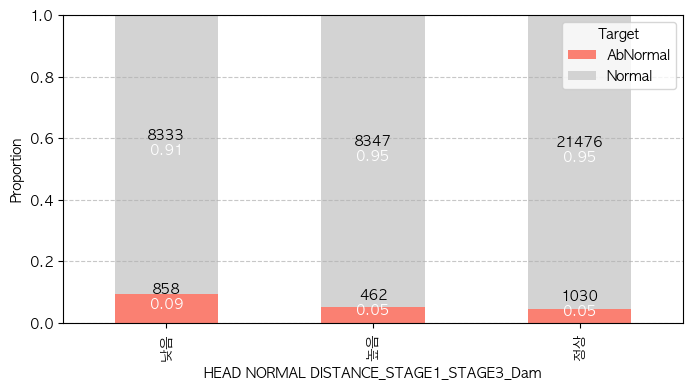

In [69]:
plot_with_counts('HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam')

In [70]:
# IQR 범주화
categorize_by_iqr(train_data, 'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam')
categorize_by_iqr(test_data,'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam')

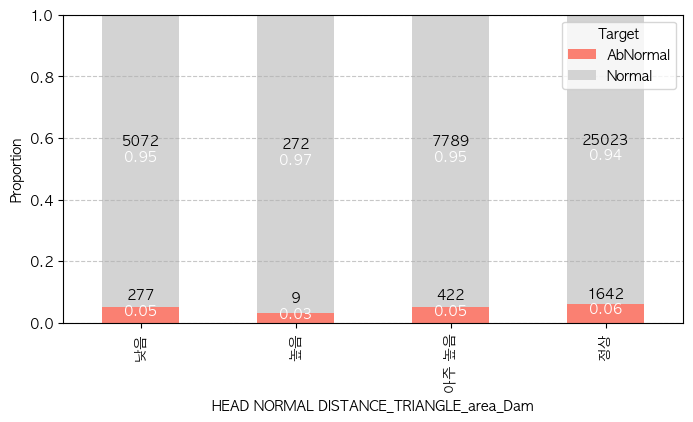

In [71]:
plot_with_counts('HEAD NORMAL DISTANCE_TRIANGLE_area_Dam')

In [72]:
# IQR 범주화
categorize_by_iqr(train_data, 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam')
categorize_by_iqr(test_data, 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam')

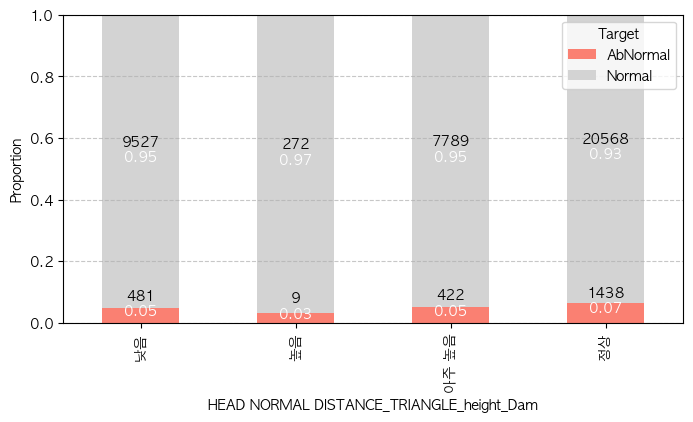

In [73]:
plot_with_counts('HEAD NORMAL DISTANCE_TRIANGLE_height_Dam')

In [74]:
# IQR 범주화
categorize_by_iqr(train_data, 'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1')
categorize_by_iqr(test_data, 'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1')

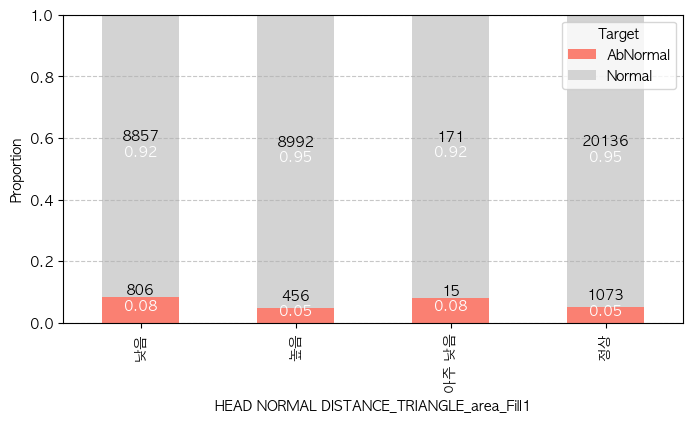

In [75]:
plot_with_counts('HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1')

In [76]:
# IQR 범주화
categorize_by_iqr(train_data, 'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1')
categorize_by_iqr(test_data, 'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1')

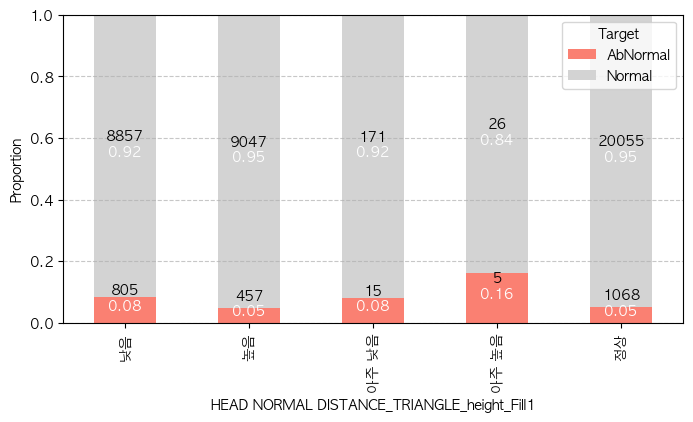

In [77]:
plot_with_counts('HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1')

- volume*time

In [78]:
'''
변수 volume_time_multip_avg_Dam의 고유값 개수: 180
변수 volume_time_multip_avg_Fill1의 고유값 개수: 161
'''

'\n변수 volume_time_multip_avg_Dam의 고유값 개수: 180\n변수 volume_time_multip_avg_Fill1의 고유값 개수: 161\n'

In [79]:
train_data['volume_time_multip_avg_Dam'].describe()

count    40506.000000
mean        12.202629
std          6.118308
min          4.617333
25%          8.996667
50%         10.976667
75%         14.344000
max         24.578000
Name: volume_time_multip_avg_Dam, dtype: float64

In [80]:
# IQR 범주화
categorize_by_iqr(train_data, 'volume_time_multip_avg_Dam')
categorize_by_iqr(test_data, 'volume_time_multip_avg_Dam')

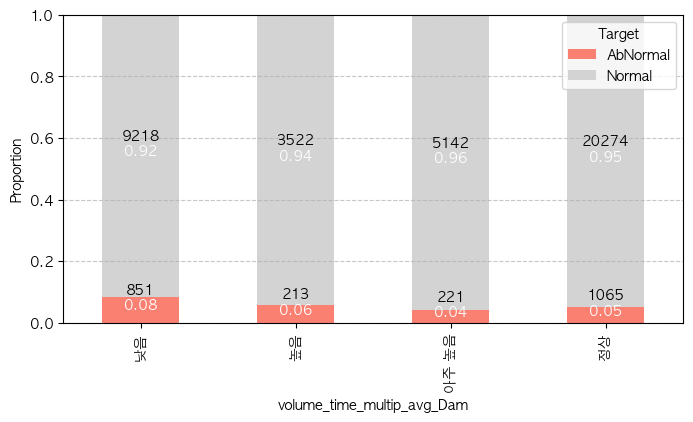

In [81]:
plot_with_counts('volume_time_multip_avg_Dam')

In [82]:
# IQR 범주화
categorize_by_iqr(train_data, 'volume_time_multip_avg_Fill1')
categorize_by_iqr(test_data, 'volume_time_multip_avg_Fill1')

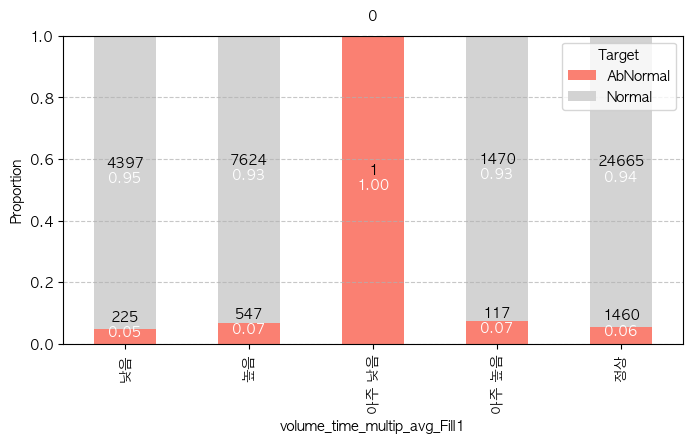

In [83]:
plot_with_counts('volume_time_multip_avg_Fill1')

- pressure*time

In [84]:
'''
변수 1st_pressure_time_AutoClave의 고유값 개수: 112
변수 2nd_pressure_time_AutoClave의 고유값 개수: 193
변수 3rd_pressure_time_AutoClave의 고유값 개수: 115
변수 avg_pressure_time_AutoClave의 고유값 개수: 1959
'''

'\n변수 1st_pressure_time_AutoClave의 고유값 개수: 112\n변수 2nd_pressure_time_AutoClave의 고유값 개수: 193\n변수 3rd_pressure_time_AutoClave의 고유값 개수: 115\n변수 avg_pressure_time_AutoClave의 고유값 개수: 1959\n'

In [85]:
# 개수로 범주화
categorize_column(train_data, 'avg_pressure_time_AutoClave', 50)
categorize_column(test_data, 'avg_pressure_time_AutoClave', 50)

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/429566337.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = data.groupby([category_column, target_column]).size().unstack(fill_value=0)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/429566337.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_values = data.groupby([category_column, target_column]).size().unstack(fill_value=0)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

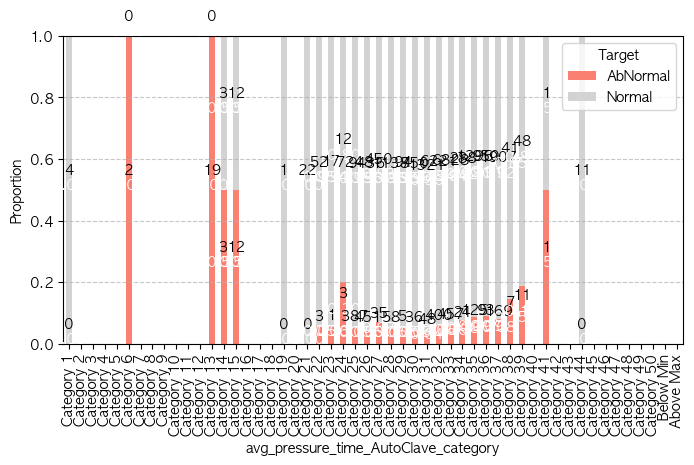

In [86]:
plot_with_counts('avg_pressure_time_AutoClave_category')

In [87]:
# IQR 범주화
categorize_by_iqr(train_data, 'avg_pressure_time_AutoClave')
categorize_by_iqr(test_data, 'avg_pressure_time_AutoClave')

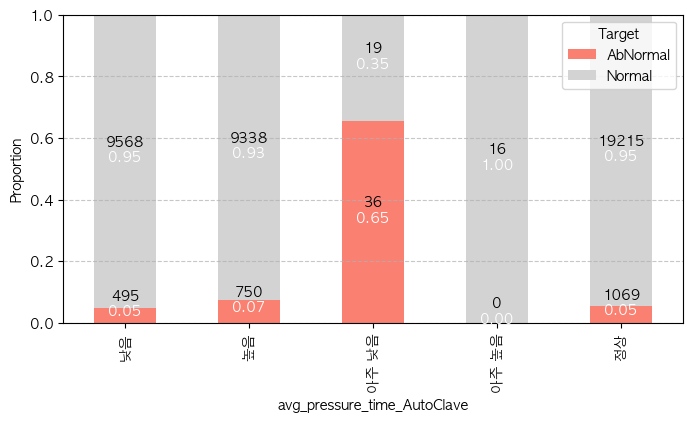

In [88]:
plot_with_counts('avg_pressure_time_AutoClave')

In [89]:
# IQR 범주화
categorize_by_iqr(train_data, '1st_pressure_time_AutoClave')
categorize_by_iqr(test_data, '1st_pressure_time_AutoClave')

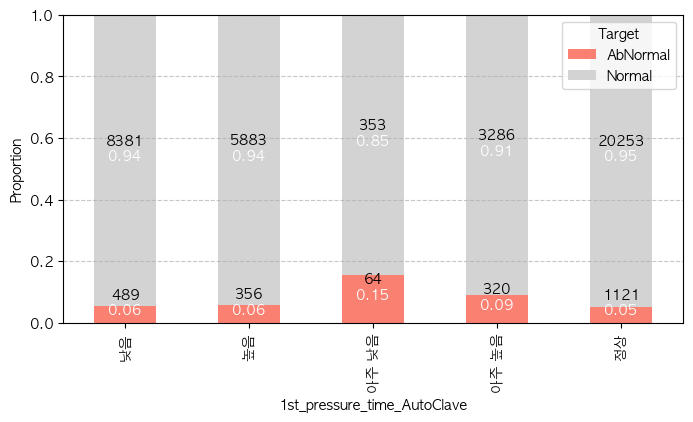

In [90]:
plot_with_counts('1st_pressure_time_AutoClave')

In [91]:
# 개수로 범주화
categorize_column(train_data, '2nd_pressure_time_AutoClave', 20)
categorize_column(test_data, '2nd_pressure_time_AutoClave', 20)

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/429566337.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = data.groupby([category_column, target_column]).size().unstack(fill_value=0)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/429566337.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_values = data.groupby([category_column, target_column]).size().unstack(fill_value=0)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

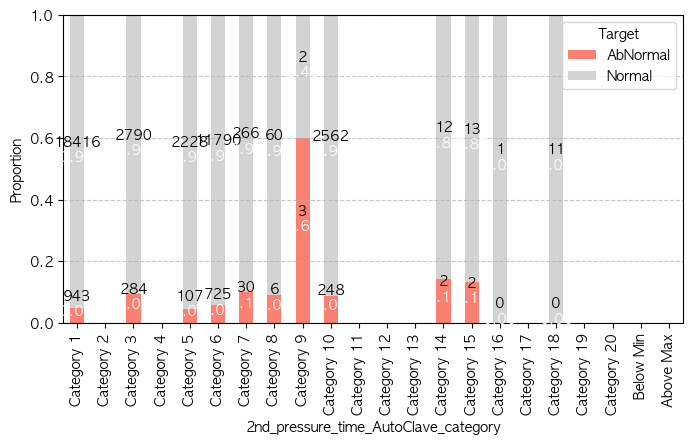

In [92]:
plot_with_counts('2nd_pressure_time_AutoClave_category')

In [93]:
# IQR 범주화
categorize_by_iqr(train_data, '2nd_pressure_time_AutoClave')
categorize_by_iqr(test_data, '2nd_pressure_time_AutoClave')

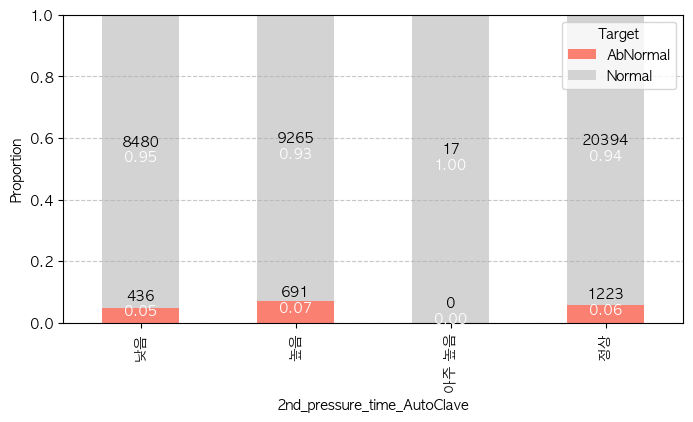

In [94]:
plot_with_counts('2nd_pressure_time_AutoClave')

In [95]:
# IQR 범주화
categorize_by_iqr(train_data, '3rd_pressure_time_AutoClave')
categorize_by_iqr(test_data, '3rd_pressure_time_AutoClave')

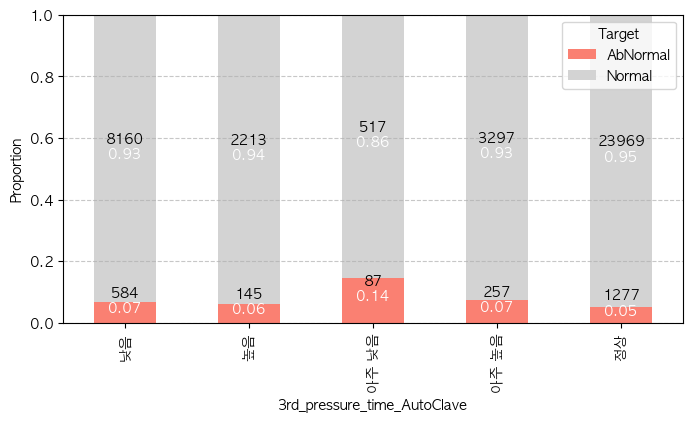

In [96]:
plot_with_counts('3rd_pressure_time_AutoClave')

- time ratio

In [97]:
'''
변수 time_ratio_Dam의 고유값 개수: 154
변수 time_ratio_Fill1의 고유값 개수: 118
변수 time_ratio_Fill2의 고유값 개수: 55
변수 time_ratio_AutoClave의 고유값 개수: 212
'''

'\n변수 time_ratio_Dam의 고유값 개수: 154\n변수 time_ratio_Fill1의 고유값 개수: 118\n변수 time_ratio_Fill2의 고유값 개수: 55\n변수 time_ratio_AutoClave의 고유값 개수: 212\n'

In [98]:
# IQR 범주화
categorize_by_iqr(train_data, 'time_ratio_Dam')
categorize_by_iqr(test_data, 'time_ratio_Dam')

- production qty

In [99]:
'''
변수 Production_Qty_Collect_Result의 고유값 개수: 607
'''

'\n변수 Production_Qty_Collect_Result의 고유값 개수: 607\n'

In [100]:
# IQR 범주화
categorize_by_iqr(train_data, 'Production_Qty_Collect_Result')
categorize_by_iqr(test_data, 'Production_Qty_Collect_Result')

In [101]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 43 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   CURE SPEED Collect Result_Dam                   40506 non-null  int64   
 1   DISCHARGED SPEED OF RESIN Collect Result_Dam    40506 non-null  int64   
 2   Head Clean Position Z Collect Result_Dam        40506 non-null  float64 
 3   Stage1_Circle_Distance_Speed_Dam                40506 non-null  float64 
 4   Stage2_Circle_Distance_Speed_Dam                40506 non-null  float64 
 5   Stage3_Circle_Distance_Speed_Dam                40506 non-null  float64 
 6   WorkMode Collect Result                         40506 non-null  float64 
 7   Chamber Temp. Collect Result_AutoClave          40506 non-null  object  
 8   DISCHARGED SPEED OF RESIN Collect Result_Fill1  40506 non-null  float64 
 9   Head Purge Position Z Collec

In [102]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 44 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Set ID                                          17361 non-null  object  
 1   CURE SPEED Collect Result_Dam                   17361 non-null  int64   
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam    17361 non-null  int64   
 3   Head Clean Position Z Collect Result_Dam        17361 non-null  float64 
 4   Stage1_Circle_Distance_Speed_Dam                17361 non-null  float64 
 5   Stage2_Circle_Distance_Speed_Dam                17361 non-null  float64 
 6   Stage3_Circle_Distance_Speed_Dam                17361 non-null  float64 
 7   WorkMode Collect Result                         17361 non-null  float64 
 8   Chamber Temp. Collect Result_AutoClave          17361 non-null  object  
 9   DISCHARGED SPEED OF RESIN Co

In [103]:
# dam, fill1, fill2 공통 변수
var_dam_fill = [
    'Equipment_same_num',
    'PalletID_Collect_Result_encoded',
    'Production_Qty_Collect_Result',
    'WorkMode Collect Result'
]

In [104]:
# 전체 공통 변수
### correlation 확인을 위한 변수 리스트
var_all_corr = [
    'model_receip_encoded',
    'workorder_receip_encoded',
]

### train
var_all_train = [
    'target',
    'model_receip_encoded',
    'workorder_receip_encoded',
]

### test
var_all_test = [
    'Set ID',
    'target',
    'model_receip_encoded',
    'workorder_receip_encoded',
]

In [105]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Dam' in var]
combined_variables

['Equipment_same_num',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result',
 'WorkMode Collect Result',
 'model_receip_encoded',
 'workorder_receip_encoded',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Stage1_Circle_Distance_Speed_Dam',
 'Stage2_Circle_Distance_Speed_Dam',
 'Stage3_Circle_Distance_Speed_Dam',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
 'volume_time_multip_avg_Dam',
 'average_thickness_Dam',
 'time_ratio_Dam',
 'stage1_line13_distance_speed_Dam_encoded',
 'stage1_line24_distance_speed_Dam_encoded',
 'stage2_line13_distance_speed_Dam_encoded',
 'stage2_line24_distance_speed_Dam_encoded',
 'stage3_line13_distance_speed_Dam_encoded',
 'stage3_line24_distance_speed_Dam_encoded']

In [106]:
# 드랍할 열 목록
columns_to_drop = [
    'Stage1_Circle_Distance_Speed_Dam',
    'Stage3_Circle_Distance_Speed_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
    'stage1_line24_distance_speed_Dam_encoded',
    'stage2_line13_distance_speed_Dam_encoded',
    'stage3_line13_distance_speed_Dam_encoded',
    'stage3_line24_distance_speed_Dam_encoded'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [107]:
# '_Dam'을 포함하는 변수 선택
dam_variables = [var for var in train_data.columns if '_Dam' in var]

# train
final_columns_train = var_dam_fill + var_all_train + dam_variables
train_data_dam = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + dam_variables
test_data_dam = test_data[final_columns_test]

In [108]:
train_data_dam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Equipment_same_num                            40506 non-null  int64  
 1   PalletID_Collect_Result_encoded               40506 non-null  float64
 2   Production_Qty_Collect_Result                 40506 non-null  object 
 3   WorkMode Collect Result                       40506 non-null  float64
 4   target                                        40506 non-null  object 
 5   model_receip_encoded                          40506 non-null  float64
 6   workorder_receip_encoded                      40506 non-null  float64
 7   CURE SPEED Collect Result_Dam                 40506 non-null  int64  
 8   DISCHARGED SPEED OF RESIN Collect Result_Dam  40506 non-null  int64  
 9   Head Clean Position Z Collect Result_Dam      40506 non-null 

In [109]:
test_data_dam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Equipment_same_num                            17361 non-null  int64  
 1   PalletID_Collect_Result_encoded               17361 non-null  float64
 2   Production_Qty_Collect_Result                 17361 non-null  object 
 3   WorkMode Collect Result                       17361 non-null  float64
 4   Set ID                                        17361 non-null  object 
 5   target                                        0 non-null      float64
 6   model_receip_encoded                          17361 non-null  float64
 7   workorder_receip_encoded                      17361 non-null  float64
 8   CURE SPEED Collect Result_Dam                 17361 non-null  int64  
 9   DISCHARGED SPEED OF RESIN Collect Result_Dam  17361 non-null 

In [112]:
from catboost import CatBoostClassifier

In [118]:
# 범주형 변수 리스트 생성
cat_features_list = variable_names = [
    'Production_Qty_Collect_Result',
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Stage2_Circle_Distance_Speed_Dam',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
    'volume_time_multip_avg_Dam',
    'average_thickness_Dam',
    'time_ratio_Dam',
]

for column in cat_features_list:
    train_data_dam[column] = train_data_dam[column].astype(str)
    test_data_dam[column] = test_data_dam[column].astype(str)

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/4139118360.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_dam[column] = train_data_dam[column].astype(str)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/4139118360.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_dam[column] = test_data_dam[column].astype(str)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/4139118360.py:16: SettingWithCopyWarning: 
A value is trying to be set 

In [148]:
# 스레드홀드 설정
RANDOM_STATE = 77

# 'Normal'과 'AbNormal'을 숫자로 변환
train_data_dam['target'] = train_data_dam['target'].map({'Normal': 0, 'AbNormal': 1})

def objectiveCatBoost(trial, x_tr, y_tr, x_val, y_val):
    param = {
        'iterations': trial.suggest_int('iterations', 400, 1800),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.4),
        'depth': trial.suggest_int('depth', 3, 16),  # 최대 16까지만 가능
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.05, 5.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 12.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 12.0),
        'border_count': trial.suggest_int('border_count', 60, 280),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 1.5),

        'random_seed': RANDOM_STATE,
        'eval_metric': 'F1',
        'logging_level': 'Silent',
        'boosting_type': 'Plain'
    }

    model = CatBoostClassifier(**param)
    model.fit(x_tr, y_tr, cat_features=cat_features_list)
    pred_proba = model.predict_proba(x_val)[:, 1]  # 양성 클래스 확률
    
    # 스레드홀드 없이 예측
    pred = (pred_proba > 0.3).astype(int)  # 일반적으로 0.3를 기준으로 예측
    
    score = f1_score(y_val, pred, average="binary")
    
    return score

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_54132/2637197477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_dam['target'] = train_data_dam['target'].map({'Normal': 0, 'AbNormal': 1})


In [120]:
# 클래스 가중치 설정
class_weights = {'Normal': 1, 'AbNormal': 5}

# 모델 파라미터 설정
params = {
    'iterations': 845, 
    'learning_rate': 0.12560723899727444, 
    'depth': 6, 
    'l2_leaf_reg': 0.11681629069236026, 
    'random_strength': 7.382448311645474, 
    'bagging_temperature': 6.190402604308831, 
    'border_count': 75, 
    'scale_pos_weight': 0.7197343250860875,
    #'class_weights': class_weights  # 클래스 가중치 추가
}

# CatBoostClassifier 모델 정의
model_Dam = CatBoostClassifier(**params, verbose=False)

In [149]:
# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 타깃값과 피쳐 분리
y = train_data_dam['target']
X = train_data_dam.drop(columns='target')

# 학습 데이터와 검증 데이터로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

In [151]:
import optuna

In [152]:
# 하이퍼 파라미터 튜닝
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(lambda trial: objectiveCatBoost(trial, X_train, y_train, X_val, y_val), n_trials=300)

print('Best trial: score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-08-20 15:13:22,109] A new study created in memory with name: no-name-76a3af87-783c-41c1-b2d6-99006e1f4399
[I 2024-08-20 15:17:01,280] Trial 0 finished with value: 0.0920863309352518 and parameters: {'iterations': 1687, 'learning_rate': 0.2747684599733494, 'depth': 13, 'l2_leaf_reg': 0.09497277778717464, 'random_strength': 1.1391026210762407, 'bagging_temperature': 9.477224490634253, 'border_count': 132, 'scale_pos_weight': 1.0410678214759677}. Best is trial 0 with value: 0.0920863309352518.
[I 2024-08-20 15:17:21,840] Trial 1 finished with value: 0.12522361359570663 and parameters: {'iterations': 736, 'learning_rate': 0.24089802395156673, 'depth': 8, 'l2_leaf_reg': 1.3469571466566936, 'random_strength': 10.056491298866218, 'bagging_temperature': 7.1029255963055276, 'border_count': 125, 'scale_pos_weight': 0.7810176906539642}. Best is trial 1 with value: 0.12522361359570663.
[I 2024-08-20 15:17:39,167] Trial 2 finished with value: 0.1142857142857143 and parameters: {'iterations'

KeyboardInterrupt: 

In [123]:
# 모델 학습
model_Dam.fit(X_train, y_train, cat_features=cat_features_list)

In [124]:
# 검증 데이터로 예측
y_val_pred = model_Dam.predict(X_val)

In [127]:
# F1 스코어 계산
f1 = f1_score(y_val, y_val_pred, pos_label='AbNormal', average="binary")  

# F1 스코어 출력
print(f'F1 Score: {f1}')

F1 Score: 0.12525252525252528


In [ ]:
### 모델 학습
# 타깃값 분리
y_train = train_data_dam['target']
x_train = train_data_dam.drop(columns='target')

# 범주형 변수 리스트 생성
cat_features_list = get_cat_features(train_data_dam)

# 랜덤 포레스트 학습
model_Dam.fit(x_train, y_train, cat_features=cat_features_list)

In [ ]:
### 모델 예측
# 'Set ID'와 'target' 컬럼 분리
set_id = test_data_dam['Set ID']  
target = test_data_dam['target']   

x_test = test_data_dam.drop(columns=['Set ID', 'target'])

test_pred = model_Dam.predict(x_test)
test_pred

In [ ]:
### 예측 컬럼 생성
df_sub["target_dam"] = test_pred
df_sub["target_dam"].value_counts()

### 13. correlation

In [54]:
# dam, fill1, fill2 공통 변수
var_dam_fill = [
    'Equipment_same_num',
    'PalletID_Collect_Result_encoded',
    'Production_Qty_Collect_Result',
    'WorkMode Collect Result'
]

In [55]:
# 전체 공통 변수
### correlation 확인을 위한 변수 리스트
var_all_corr = [
    'model_receip_encoded',
    'workorder_receip_encoded'
]

### train
var_all_train = [
    'target',
    'model_receip_encoded',
    'workorder_receip_encoded'
]

### test
var_all_test = [
    'Set ID',
    'target',
    'model_receip_encoded',
    'workorder_receip_encoded'
]

- dam

In [56]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Dam' in var]
combined_variables

['Equipment_same_num',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result',
 'WorkMode Collect Result',
 'model_receip_encoded',
 'workorder_receip_encoded',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Head Purge Position Z Collect Result_Dam',
 'Head Zero Position Y Collect Result_Dam',
 'Stage1_Circle_Distance_Speed_Dam',
 'Stage2_Circle_Distance_Speed_Dam',
 'Stage3_Circle_Distance_Speed_Dam',
 'CURE_DISTANCE_Dam',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
 'volume_time_multip_avg_Dam',
 'average_thickness_Dam',
 'time_ratio_Dam',
 'stage1_line13_distance_speed_Dam_encoded',
 'stage1_line24_distance_speed_Dam_encoded',
 'stage2_line13_distance_speed_Dam_encoded',
 'stage2_line24_distance_speed_Dam_encoded',
 'stage3_line13_distance_speed_Dam_encoded',
 'stage3_line24_distance_speed_Dam_encoded'

In [ ]:
variables = ['Equipment_same_num',   
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result',
 'WorkMode Collect Result',
 'model_receip_encoded',
 'workorder_receip_encoded',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Head Purge Position Z Collect Result_Dam',
 'Head Zero Position Y Collect Result_Dam',
 #'Stage1_Circle_Distance_Speed_Dam',
 'Stage2_Circle_Distance_Speed_Dam',
 #'Stage3_Circle_Distance_Speed_Dam',
 'CURE_DISTANCE_Dam',
 #'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
 'volume_time_multip_avg_Dam',
 'average_thickness_Dam',
 'time_ratio_Dam',
 'stage1_line13_distance_speed_Dam_encoded',
 #'stage1_line24_distance_speed_Dam_encoded',
 #'stage2_line13_distance_speed_Dam_encoded',
 'stage2_line24_distance_speed_Dam_encoded',
 #'stage3_line13_distance_speed_Dam_encoded',
 #'stage3_line24_distance_speed_Dam_encoded'
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [ ]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

In [ ]:
# 드랍할 열 목록
columns_to_drop = [
    'Stage1_Circle_Distance_Speed_Dam',
    'Stage3_Circle_Distance_Speed_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
    'stage1_line24_distance_speed_Dam_encoded',
    'stage2_line13_distance_speed_Dam_encoded',
    'stage3_line13_distance_speed_Dam_encoded',
    'stage3_line24_distance_speed_Dam_encoded'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
# '_Dam'을 포함하는 변수 선택
dam_variables = [var for var in train_data.columns if '_Dam' in var]

# train
final_columns_train = var_dam_fill + var_all_train + dam_variables
train_data_dam = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + dam_variables
test_data_dam = test_data[final_columns_test]

In [ ]:
train_data_dam.info()

In [ ]:
test_data_dam.info()

- fill1

In [ ]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Fill1' in var]
combined_variables

In [ ]:
variables = ['Equipment_same_num',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result',
 'WorkMode Collect Result',
 'model_receip_encoded',
 'workorder_receip_encoded',
 'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
 'Head Purge Position Z Collect Result_Fill1',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1',
 #'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1',
 'volume_time_multip_avg_Fill1',
 'time_ratio_Fill1']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [ ]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

In [ ]:
# 드랍할 열 목록
columns_to_drop = ['HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1']

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
# '_Fill1'을 포함하는 변수 선택
fill1_variables = [var for var in train_data.columns if '_Fill1' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill1_variables
train_data_fill1 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill1_variables
test_data_fill1 = test_data[final_columns_test]

In [ ]:
train_data_fill1.info()

In [ ]:
test_data_fill1.info()

- fill2

In [ ]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Fill2' in var]
combined_variables

In [ ]:
variables = ['Equipment_same_num',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result',
 'WorkMode Collect Result',
 'model_receip_encoded',
 'workorder_receip_encoded',
 'CURE SPEED Collect Result_Fill2',
 'Head Purge Position Z Collect Result_Fill2',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2',
 #'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
 #'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
 'time_ratio_Fill2',
 'cure_end_position_XZ_Fill2_encoded',
 'cure_start_position_XZ_Fill2_encoded']
 #'cure_standby_position_XZ_Fill2_encoded']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [ ]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

In [ ]:
# 드랍할 열 목록
columns_to_drop = [
    'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
    'cure_standby_position_XZ_Fill2_encoded'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
# '_Fill2'을 포함하는 변수 선택
fill2_variables = [var for var in train_data.columns if '_Fill2' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill2_variables
train_data_fill2 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill2_variables
test_data_fill2 = test_data[final_columns_test]

In [ ]:
train_data_fill2.info()

In [ ]:
test_data_fill2.info()

- autoclave

In [ ]:
# 상관관계를 확인할 데이터셋
combined_variables = var_all_corr + [var for var in train_data.columns if '_AutoClave' in var]
combined_variables

In [ ]:
variables = ['model_receip_encoded',
 'workorder_receip_encoded',
 'Chamber Temp. Collect Result_AutoClave',
 '1st_pressure_time_AutoClave',
 '2nd_pressure_time_AutoClave',
 '3rd_pressure_time_AutoClave',
 #'avg_pressure_time_AutoClave',
 'time_ratio_AutoClave']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [ ]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

In [ ]:
# 드랍할 열 목록
columns_to_drop = ['avg_pressure_time_AutoClave']

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
# '_AutoClave'을 포함하는 변수 선택
autoclave_variables = [var for var in train_data.columns if '_AutoClave' in var]

# train
final_columns_train = var_all_train + autoclave_variables
train_data_autoclave = train_data[final_columns_train]

# test 
final_columns_test = var_all_test + autoclave_variables
test_data_autoclave = test_data[final_columns_test]

In [ ]:
train_data_autoclave.info()

In [83]:
test_data_autoclave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Set ID                                  17361 non-null  object 
 1   target                                  0 non-null      float64
 2   model_receip_encoded                    17361 non-null  float64
 3   workorder_receip_encoded                17359 non-null  float64
 4   Chamber Temp. Collect Result_AutoClave  17361 non-null  int64  
 5   1st_pressure_time_AutoClave             17361 non-null  float64
 6   2nd_pressure_time_AutoClave             17361 non-null  float64
 7   3rd_pressure_time_AutoClave             17361 non-null  float64
 8   time_ratio_AutoClave                    17361 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.2+ MB
